In [9]:
import numpy as np

X = np.load("X_mel.npy")      # shape: (N, 128, 128, 1)
y = np.load("y_labels.npy")  # shape: (N,)

print(X.shape, y.shape)


(6705, 128, 128, 1) (6705,)


In [10]:
from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(y))
y = to_categorical(y, num_classes)

print("Number of classes:", num_classes)
print("y shape:", y.shape)


Number of classes: 11
y shape: (6705, 11)


In [11]:
from sklearn.model_selection import train_test_split

# Train (70%) + Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# Validation (15%) + Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (4693, 128, 128, 1)
Val: (1006, 128, 128, 1)
Test: (1006, 128, 128, 1)


In [12]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_labels = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.5685160427807487), 1: np.float64(1.2086015967035797), 2: np.float64(1.350115074798619), 3: np.float64(0.9565837749694251), 4: np.float64(0.801948051948052), 5: np.float64(0.8944158566800077), 6: np.float64(0.8448244824482448), 7: np.float64(0.9740556247405563), 8: np.float64(1.056030603060306), 9: np.float64(1.0508284818629645), 10: np.float64(0.7842580213903744)}


In [13]:
import numpy as np

def spec_augment(mel, freq_mask=15, time_mask=20):
    mel = mel.copy()

    # Frequency masking
    f = np.random.randint(0, freq_mask)
    f0 = np.random.randint(0, mel.shape[0] - f)
    mel[f0:f0 + f, :] = 0

    # Time masking
    t = np.random.randint(0, time_mask)
    t0 = np.random.randint(0, mel.shape[1] - t)
    mel[:, t0:t0 + t] = 0

    return mel


In [14]:
# Remove channel dim → apply augment → add back
X_train_aug = np.array([
    spec_augment(x.squeeze()) for x in X_train
])
X_train_aug = X_train_aug[..., np.newaxis]

# Combine original + augmented
X_train_combined = np.concatenate([X_train, X_train_aug])
y_train_combined = np.concatenate([y_train, y_train])

print("Original train:", X_train.shape)
print("Augmented train:", X_train_combined.shape)


Original train: (4693, 128, 128, 1)
Augmented train: (9386, 128, 128, 1)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D,
    BatchNormalization, Flatten,
    Dense, Dropout
)
from tensorflow.keras.regularizers import l2

model = Sequential()

model.add(Input(shape=(128, 128, 1)))

# Conv Block 1
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

# Conv Block 2
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

# Conv Block 3
model.add(Conv2D(64, (3,3), activation="relu",
                 kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

# Dense head
from tensorflow.keras.layers import GlobalAveragePooling2D

model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation="relu",
                kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))


# Output (SINGLE-LABEL → softmax)
model.add(Dense(num_classes, activation="softmax"))

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,123 (258.29 KB)

 Trainable params: 65,803 (257.04 KB)

 Non-trainable params: 320 (1.25 KB)

In [16]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)


In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=2,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=2,
    min_lr=1e-5
)


In [18]:
history = model.fit(
    X_train_combined, y_train_combined,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    class_weight=class_weights
)


Epoch 1/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 45s 142ms/step - accuracy: 0.2795 - loss: 2.3174 - val_accuracy: 0.1054 - val_loss: 3.1544 - learning_rate: 3.0000e-04
Epoch 2/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - accuracy: 0.4181 - loss: 2.0295 - val_accuracy: 0.2992 - val_loss: 2.1952 - learning_rate: 3.0000e-04
Epoch 3/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - accuracy: 0.4940 - loss: 1.8600 - val_accuracy: 0.4443 - val_loss: 1.8884 - learning_rate: 3.0000e-04
Epoch 4/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 45s 152ms/step - accuracy: 0.5471 - loss: 1.7415 - val_accuracy: 0.4533 - val_loss: 1.9037 - learning_rate: 3.0000e-04
Epoch 5/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 40s 136ms/step - accuracy: 0.5820 - loss: 1.6569 - val_accuracy: 0.5964 - val_loss: 1.6101 - learning_rate: 3.0000e-04
Epoch 6/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 40s 136ms/step - accuracy: 0.6211 - loss: 1.5784 - val_accuracy: 0.5716 - val_loss: 1.6905 - learning_rate: 3.0000e-04
Epoch 7/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 42s 14

In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5417 - loss: 1.7045
Test Accuracy: 0.5417494773864746


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


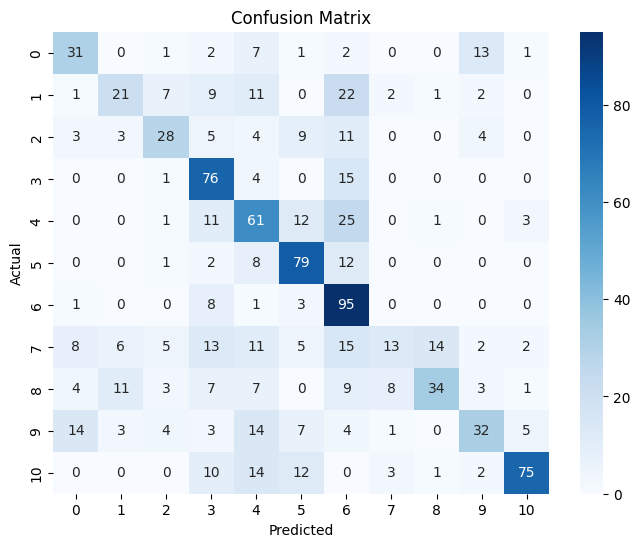

              precision    recall  f1-score   support

           0       0.50      0.53      0.52        58
           1       0.48      0.28      0.35        76
           2       0.55      0.42      0.47        67
           3       0.52      0.79      0.63        96
           4       0.43      0.54      0.48       114
           5       0.62      0.77      0.69       102
           6       0.45      0.88      0.60       108
           7       0.48      0.14      0.21        94
           8       0.67      0.39      0.49        87
           9       0.55      0.37      0.44        87
          10       0.86      0.64      0.74       117

    accuracy                           0.54      1006
   macro avg       0.56      0.52      0.51      1006
weighted avg       0.56      0.54      0.52      1006



In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_cls)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred_cls))


In [26]:
# Save model
model.save("irmas_cnn_final.h5")

print("✅ Model saved as irmas_cnn_final.h5")


✅ Model saved as irmas_cnn_final.h5


In [27]:
# Save model
model.save("irmas_cnn_final.keras")

print("✅ Model saved as irmas_cnn_final.h5")


✅ Model saved as irmas_cnn_final.h5


In [23]:
from tensorflow.keras.models import load_model

model = load_model("irmas_cnn_final.h5")

print("✅ Model loaded successfully")


✅ Model loaded successfully


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


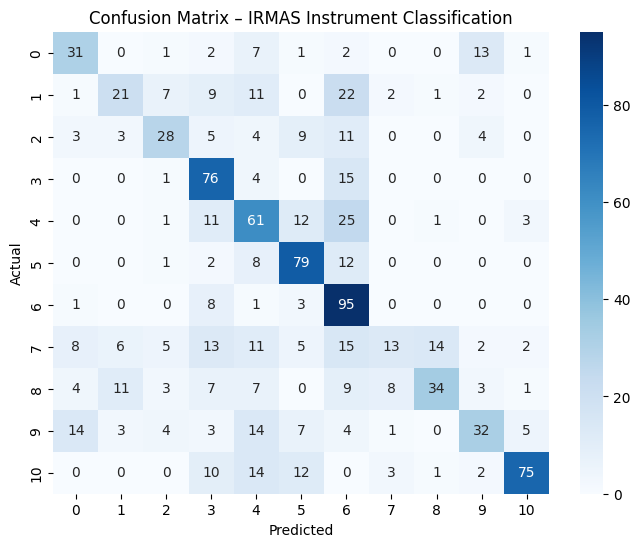

              precision    recall  f1-score   support

           0       0.50      0.53      0.52        58
           1       0.48      0.28      0.35        76
           2       0.55      0.42      0.47        67
           3       0.52      0.79      0.63        96
           4       0.43      0.54      0.48       114
           5       0.62      0.77      0.69       102
           6       0.45      0.88      0.60       108
           7       0.48      0.14      0.21        94
           8       0.67      0.39      0.49        87
           9       0.55      0.37      0.44        87
          10       0.86      0.64      0.74       117

    accuracy                           0.54      1006
   macro avg       0.56      0.52      0.51      1006
weighted avg       0.56      0.54      0.52      1006



In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_pred = model.predict(X_test)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_cls)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – IRMAS Instrument Classification")
plt.show()

# Classification report
print(classification_report(y_true, y_pred_cls))
